In [4]:
import numpy as np , pandas as pd
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torch.utils as utils

import matplotlib.pyplot as plt
import einops
from tqdm import tqdm

In [5]:
fer = pd.read_csv("../archive/fer2013/fer2013/fer2013.csv")
fer[:2] # show first 2 examples

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


In [6]:
fer_train = fer[fer.Usage == "Training"]
fer_valid = fer[fer.Usage == "PublicTest"]
fer_test = fer[fer.Usage == "PrivateTest"]

fer_train.shape ,fer_valid.shape, fer_test.shape

((28709, 3), (3589, 3), (3589, 3))

In [15]:
# actually we need to flatten all the patches individually .. and then make a single x out of it
# but for illustration we will keep this operation in the model
class FerDataset(utils.data.Dataset):
    """
    Keep the validation
    and test set seperate for now.
    Dont plan to use early stopping.
    just to make sure we are not leaking into validation Dataset
    """

    def __init__(self,df,label = None, transformations = None):
        super().__init__()
        if label not in ("train", "test", "valid"):
            raise ValueError("Please give al label to this dataset class train , valid , test")

        # handy stuff that i often call
        self.label = label

        self.data = df[df.columns[:-1]] # the last column is just usage
        self.columns = self.data.columns
        self.shape = self.data.shape
        self.transforms = transformations

        if self.transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(), # this actually makes the images [0,1] but we want to keep it in uint8 as we are going to pass it through an embedding layer
                transforms.Resize((32,32), antialias=True)]) # limit number of patches (4) calculation.. keep this a multiple of 16*16

    # mandatory method to calculate random indexes when you turn on shuffle in dataloader
    def __len__(self):
        return self.shape[0]


    def get_patches(self, arr):
        # best place to use einops
        # squueze out the channel dimension.. the loader will add it ..
        arr = einops.rearrange(arr,"1 h w -> h w") 
        patches = einops.rearrange(
            arr, "(p1 h) (p2 w) ->(p1 p2) h w",p1=2 , p2=2
        ) # lay it on as the batch for the image
        # we need to crop twice for a 48 * 48 image to get a 16 * 16 patch
        return patches



    def __getitem__(self, idx):
        # convert to string type

        self.data = self.data.astype({"emotion": int, "pixels": str})

        features = self.data.iloc[idx]['pixels']
        features = np.array(features.split(" "),dtype=np.uint8) # its a flatten of 48 * 48 * 1 image
        # image = features.view(48,48) -> numpy view is like astype with view not like torch.view
        image = features.reshape(48,48)
        if self.transforms:
            image = self.transforms(image)
        patches = self.get_patches(image)

        label = self.data.iloc[idx]['emotion']


        return patches, label # dont use capital Tensor it will convert it into float

   

In [17]:
fer = FerDataset(fer_train, "train")
patches,lab = fer[0]
type(patches) , patches.shape , lab

(torch.Tensor, torch.Size([4, 16, 16]), 0)

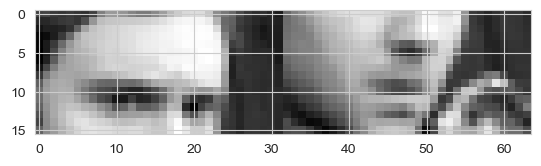

In [23]:
plt.imshow(
    einops.rearrange(patches,"b h w ->  h (b w)"),
    cmap="gray"
)

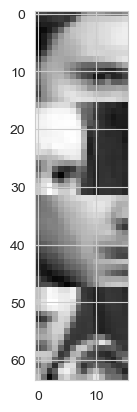

In [22]:
# actually it looks like its only been cropped twice in the above cell.
# but if you lay down in columns you could see the patches more clearly
plt.imshow(
    einops.rearrange(patches,"b h w -> (b h) w"),
    cmap="gray"
)

In [28]:
train_data = FerDataset(fer_train,"train")
train_loader = utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

valid_data = FerDataset(fer_valid,"valid")
valid_loader = utils.data.DataLoader(valid_data, shuffle=True, batch_size=32)

test_data = FerDataset(fer_test,"test")
test_loader = utils.data.DataLoader(test_data, shuffle=True, batch_size=32)

In [29]:
# check appendix for unit test of this class
class SingleHead(nn.Module):
    """
    Implements a single head of attention (unmasked)
    """

    def __init__(self,n_embed=32,head_size=8):
        super().__init__()
        # single head
        self.head_size = torch.tensor(head_size)
        self.n_embed = torch.tensor(n_embed)
        self.Q = nn.Parameter( torch.randn(self.n_embed,head_size) * (1/torch.tensor(2.82)))
        self.K = nn.Parameter( torch.randn(self.n_embed,head_size) * (1/torch.tensor(2.82)))
        self.V = nn.Parameter( torch.randn(self.n_embed,head_size) * (1/torch.tensor(2.82)))

    def forward(self,x):
        query = x @ self.Q
        key =   x @ self.K
        value=  x @ self.V
        
        # hand implementation
        # scale => sqrt head size
        scale = 1 / torch.sqrt(self.head_size)

        # we will not use any masking here as its an image
        # and no dropout consideration in this implementation
        comm = query @ key.transpose(-2,-1)
        comm = comm* scale
        soft_comm = torch.softmax(comm, dim=2)
        att = soft_comm @ value
        
        return att

In [30]:
class Multihead(nn.Module):
    def __init__(self,n_embed,n_heads):
        super().__init__()
        
        self.n_embed = n_embed
        self.n_heads = n_heads
        self.head_size = self.n_embed // self.n_heads
 
        self.multiheads = nn.ModuleList(
            [SingleHead(self.n_embed,self.head_size)
             for _ in range(self.n_heads)]
        )

    def forward(self,x):
        return torch.cat([head(x) for head in self.multiheads],dim=2)

In [31]:
# only multihead ->  skip connection -> layernorm
# Batch norm : couples examples in and normalizes it .. (also has a regularization effect) but we need to keep a running mean to track new mean and sigma
# layernorm : normalizes the features of each example (does not couple examples across the batch) more popular in transformers

class TranformerBlock(nn.Module):
    def __init__(self, n_embed,n_head):
        super().__init__()
        self.multi_head = Multihead(n_embed,n_head)
        # i am not going to implement my own layer norm it wont be efficient and will be janky at best
        self.norm = nn.LayerNorm(n_embed) # we want to normalize feeatures (each patch gets normalized)
    
    def forward(self,x):
        # pass through multihead
        attention = self.multi_head(x)
        # skip connection and non linarity
        attention = torch.relu( x + attention)
        # layer norm
        attention = self.norm(attention)
        return attention # B , n_patch , n_embed
        ...

In [41]:
# most of the comments are pasted verbatim from the paper
class SmallVIT(nn.Module):
    
    def __init__(self):
        super().__init__()
        # patches
        # embedding
        self.vocab_size = torch.tensor(256) # 0 to 255 pixels
        # each patch will only get one n_embed representation
        self.n_embed = 32 # we will project each patch 16*16 to a 32 dimensional representation
        # so the lookup table would be of the shape
        # unlike in nlp where we embed token to a vector like below we would project matrix of patch size to a vector
        # self.C = nn.Embedding(self.vocab_size, self.n_embed)
        
        self.C = nn.Parameter(torch.randn(self.vocab_size, self.n_embed) * 1/torch.sqrt(self.vocab_size) )
        
        # positional embedding
        # the paper says Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings 
        self.pe = nn.Parameter(torch.randn(1,4,self.n_embed)) # each pach and representation should get positional embedding
        
        # we use the standard approach of adding an extra learnable “classification token” to the sequence
        self.classification_token = nn.Parameter(torch.randn(1, 1, self.n_embed))
        # we will keep the step above optional .. i dont understand why we should use it yet.
        
        # transformer block
        self.n_heads = 4 # we will use 4 heads for now
        self.transformer_block = TranformerBlock(self.n_embed,self.n_heads)
        
        # MLP Head for final logit calculation
        # n_patch * n_embed -> fer["emotion"].nuinque() : 7
        self.mlp_head = nn.Parameter(torch.randn(4*32, 7) * torch.sqrt(torch.tensor(4*32)))
        
        
        
        
        ...
       
    def forward(self,X):
        batch_size = X.shape[0]
        # flatten the patches
        patches = einops.rearrange(X,"b p h w -> b p (h w)")
        # B , p_num , 256 @ 256 , 32
        emb = patches @ self.C # B , p_num , n_embed
        emb = emb + self.pe # kind of acts like a bias towards each patches.
        
        # 2 transformers
        tf = self.transformer_block(emb)
        tf = self.transformer_block(tf)
        
        # flatten it : across patches
        tf = tf.view(batch_size,-1)
        
        # logits
        logits = tf @ self.mlp_head
        
        
        

        # broadcasting steps in the above command
        # B,p_n , p*p , n_embed
        #1,4,32


        return logits

        
        
        
        
        

In [43]:
vit = SmallVIT() # testing the shapes in the forward pass
with torch.no_grad():
    for x_ex , lab in train_loader:
        print(x_ex.shape,lab.shape)
        out = vit(x_ex)
        print(out.shape)
        break

torch.Size([32, 4, 16, 16]) torch.Size([32])
torch.Size([32, 7])


In [45]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
# only train the parameters with requires_grad set to True
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vit.parameters()), lr=0.0001)


In [46]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
train_on_gpu

False

In [47]:
# Train model

# number of epochs ... this needs to be way higher .
# mostly transformer based model are done for really high epochs
n_epoch = 10

train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    vit.to('cuda')

# prepare model for training
vit.train()

for e in range(n_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in tqdm( enumerate(train_loader)):

        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to('cuda'), targets.to('cuda')

        # clear grad
        optimizer.zero_grad()

        # feedforward data
        outputs = vit(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vit.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to('cuda')
            targets = targets.to('cuda')

        # turn off gradients
        with torch.no_grad():

            outputs = vit(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vit.train()

    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
          .format( (e+1), train_loss, valid_loss))



898it [00:41, 21.63it/s]


Epoch: 1 	 Training Loss: 30.118047 	 Validation Loss: 10.205763


898it [00:40, 22.24it/s]


Epoch: 2 	 Training Loss: 7.936310 	 Validation Loss: 6.484917


898it [00:41, 21.88it/s]


Epoch: 3 	 Training Loss: 5.382563 	 Validation Loss: 4.469577


898it [01:11, 12.50it/s]


Epoch: 4 	 Training Loss: 4.113414 	 Validation Loss: 4.007691


898it [00:39, 22.48it/s]


Epoch: 5 	 Training Loss: 3.492097 	 Validation Loss: 3.252780


898it [00:39, 22.63it/s]


Epoch: 6 	 Training Loss: 3.114487 	 Validation Loss: 2.989989


898it [00:39, 22.71it/s]


Epoch: 7 	 Training Loss: 2.831545 	 Validation Loss: 2.705537


898it [00:44, 20.35it/s]


Epoch: 8 	 Training Loss: 2.609739 	 Validation Loss: 2.536017


898it [00:40, 22.40it/s]


Epoch: 9 	 Training Loss: 2.459895 	 Validation Loss: 2.427808


898it [00:40, 22.33it/s]


Epoch: 10 	 Training Loss: 2.339044 	 Validation Loss: 2.485343


In [48]:
torch.save(vit.state_dict(), "./hand_vit_weights.pth")

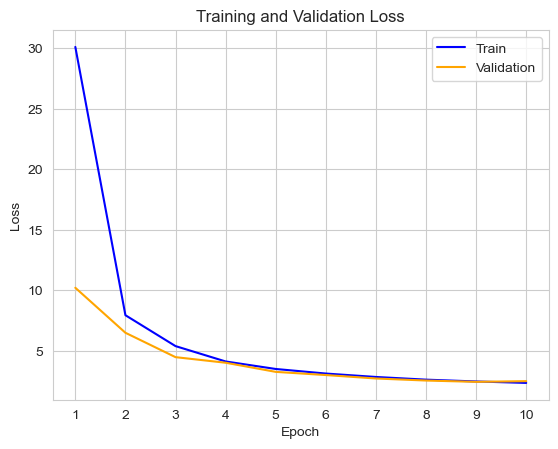

In [49]:
# visualize loss statistics

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plot losses
x = list(range(1, n_epoch + 1))
plt.plot(x, train_loss_list, color ="blue", label='Train')
plt.plot(x, valid_loss_list, color="orange", label='Validation')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [50]:
# test loss (showed no overfitting)
import torch.nn.functional as F
# prepare model for evaluation
vit.eval()

test_loss = 0.0
accuracy = 0

# number of classes
n_class = 7

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vit = vit.to('cpu')

# test model
for images, targets in tqdm(test_loader):

    # get outputs
    outputs = vit(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))


100%|██████████| 113/113 [00:02<00:00, 54.60it/s]

Test Loss: 2.496379


In [51]:
classes =  ["Angry","Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [52]:
class_accuracy = class_correct / class_total

print('Test Accuracy of Classes')
print()

for c in range(n_class):
    print('{}\t: {}% \t ({}/{})'.format(classes[c],
                                        int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )

print()
print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                           int(np.sum(class_correct)), int(np.sum(class_total)) ))

Test Accuracy of Classes

Angry	: 12% 	 (61/491)
Disgust	: 0% 	 (0/55)
Fear	: 31% 	 (168/528)
Happy	: 62% 	 (551/879)
Sad	: 11% 	 (68/594)
Surprise	: 13% 	 (56/416)
Neutral	: 10% 	 (64/626)

Test Accuracy of Dataset: 	 26% 	 (968/3589)


In [97]:
# we will try to improve on this in vit_pretrained notebook

# Appendix

In [98]:
# unit teset

# single head unit test

In [85]:
g=torch.Generator().manual_seed(123)
query, key, value = torch.randn(2, 3, 8 , generator = g), torch.randn(2, 3, 8, generator = g), torch.randn(2, 3, 8 , generator = g)

In [86]:
# pytorch implementation
py_sa = nn.functional.scaled_dot_product_attention(query, key, value)
py_sa.shape

torch.Size([2, 3, 8])

In [87]:
def single_head(query, key,value):
    head_size = torch.tensor(query.shape[-1])
    # hand implementation
    # scale => sqrt head size
    scale = 1 / torch.sqrt(head_size)

    # we will not use any masking here as its an image
    # and no dropout consideration in this implementation
    comm = query @ key.transpose(-2,-1)
    comm = comm* scale
    soft_comm = torch.softmax(comm, dim=2)
    att = soft_comm @ value
    print(att.shape)
    return att
sh  = single_head(query,key,value)

torch.Size([2, 3, 8])


In [88]:
torch.allclose(py_sa , sh)

True

In [89]:
fer_train["emotion"].nunique()

7